# Interactive Quantum Portfolio Optimization with QAOA

A practical implementation of quantum approximate optimization for portfolio selection using real market data.

**New Features:**
- Interactive user input for shares and budget
- Real-time stock price fetching
- Intelligent share allocation across MSFT, TSLA, and AAPL
- Detailed investment breakdown with profit projections

In [80]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import yfinance as yf

from src import fetch_market_data, ManualPortfolioQUBO, PortfolioSolver

print("✅ All modules imported successfully!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ All modules imported successfully!


## 1. User Configuration

Specify your investment parameters:

In [81]:

print(" QUANTUM PORTFOLIO OPTIMIZATION - INTERACTIVE ")
print("="*60)
print("Available companies: MSFT (Microsoft), TSLA (Tesla), AAPL (Apple)\n")

total_shares = int(input("How many total shares do you want to buy? (minimum 5): "))
budget_per_share = float(input("What's your maximum budget per share in USD? (e.g., 500): $"))

total_budget = total_shares * budget_per_share

print(f"\n✓ Configuration Accepted:")
print(f"  - Total Shares: {total_shares}")
print(f"  - Budget per Share: ${budget_per_share:.2f}")
print(f"  - Total Budget: ${total_budget:.2f}")

 QUANTUM PORTFOLIO OPTIMIZATION - INTERACTIVE 
Available companies: MSFT (Microsoft), TSLA (Tesla), AAPL (Apple)


✓ Configuration Accepted:
  - Total Shares: 4
  - Budget per Share: $200.00
  - Total Budget: $800.00


## 2. Market Data Acquisition

Extract historical price data and compute statistical metrics for portfolio construction.

In [86]:
current_prices = {}
print(" 💲 Current Stock Prices:")
print("="*40)

for ticker in assets:
    stock = yf.Ticker(ticker)
    
    # Try to get current price with error handling
    try:
        hist = stock.history(period='1d')
        
        # Check if we got valid data
        if hist is None or hist.empty:
            print(f"⚠️  Warning: No data for {ticker}, trying 5d period...")
            hist = stock.history(period='5d')
        
        if hist is None or hist.empty:
            # Use the last price from price_data as fallback
            current_price = price_data[ticker].iloc[-1]
            print(f"{ticker:>6}: ${current_price:> 8.2f} per share (from historical data)")
        else:
            current_price = hist['Close'].iloc[-1]
            current_prices[ticker] = current_price
            print(f"{ticker:>6}: ${current_price:> 8.2f} per share")
            
        current_prices[ticker] = current_price
        
    except Exception as e:
        # If all else fails, use the last price from our already-fetched data
        current_price = price_data[ticker].iloc[-1]
        current_prices[ticker] = current_price
        print(f"{ticker:>6}: ${current_price:> 8.2f} per share (fallback)")
        print(f"   ℹ️  Note: Using historical data due to API issue")

print(f"\n📊 Budget Analysis:")
print(f"   Your total budget: ${total_budget:.2f}")
print(f"   Total shares to allocate: {total_shares}")

 💲 Current Stock Prices:
  MSFT: $  459.86 per share
  TSLA: $  437.50 per share
  AAPL: $  255.53 per share

📊 Budget Analysis:
   Your total budget: $800.00
   Total shares to allocate: 4


### Current Stock Prices

In [87]:
current_prices = {}
print(" 💲 Current Stock Prices:")
print("="*40)
for ticker in assets:
    stock = yf.Ticker(ticker)
    current_price = stock.history(period='1d')['Close'].iloc[-1]
    current_prices[ticker] = current_price
    print(f"{ticker:>6}: ${current_price:> 8.2f} per share")

print(f"\n📊 Budget Analysis:")
print(f"   Your total budget: ${total_budget:.2f}")
print(f"   Total shares to allocate: {total_shares}")

 💲 Current Stock Prices:
  MSFT: $  459.86 per share
  TSLA: $  437.50 per share
  AAPL: $  255.53 per share

📊 Budget Analysis:
   Your total budget: $800.00
   Total shares to allocate: 4


### Price Trends 💹

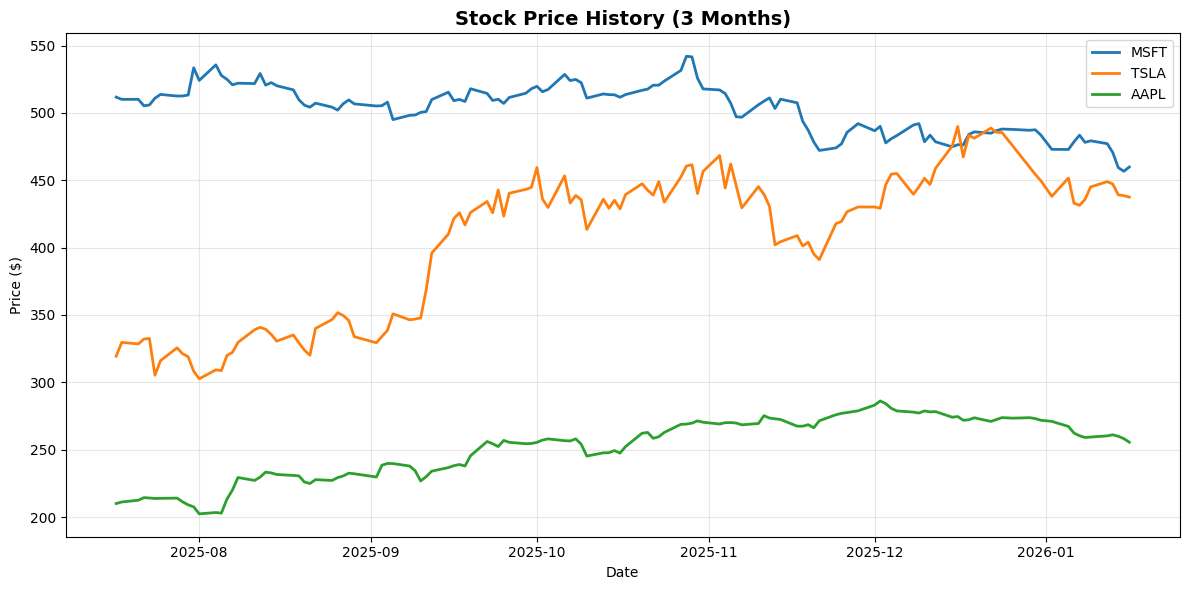

In [88]:
plt.figure(figsize=(12, 6))
for ticker in assets:
    plt.plot(price_data.index, price_data[ticker], label=ticker, linewidth=2)

plt.title('Stock Price History (3 Months)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Return Analysis

In [89]:
print("Expected Returns:")
print("="*50)
for i, ticker in enumerate(assets):
    print(f"{ticker:>6}: {expected_returns[i]:.6f} ({expected_returns[i]*100:.4f}% daily)")

returns_df = pd.DataFrame({
    'Stock': assets,
    'Daily Return': expected_returns.values,
    'Daily Return (%)': expected_returns.values * 100,
    'Annual Return (%)': expected_returns.values * 252 * 100
})

display(returns_df)

Expected Returns:
  MSFT: 0.001635 (0.1635% daily)
  TSLA: -0.000775 (-0.0775% daily)
  AAPL: 0.002879 (0.2879% daily)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9724\708457498.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{ticker:>6}: {expected_returns[i]:.6f} ({expected_returns[i]*100:.4f}% daily)")


,Stock,Daily Return,Daily Return (%),Annual Return (%)
0,MSFT,0.001635,0.163493,41.200292
1,TSLA,-0.000775,-0.077529,-19.537420
2,AAPL,0.002879,0.287863,72.541405


### Risk Matrix

In [90]:
print("Covariance Matrix:")
risk_df = pd.DataFrame(risk_matrix, index=assets, columns=assets)
display(risk_df)

# Sanity check
var_values = np.diag(risk_matrix)
print("\nVariance Check:")
for i, ticker in enumerate(assets):
    check = "✓" if var_values[i] > 0 else "✗"
    print(f"{ticker}: {var_values[i]:.8f} {check}")

if np.all(var_values > 0):
    print("\nAll variances positive - data validated")

Covariance Matrix:


,MSFT,TSLA,AAPL
MSFT,0.000132,0.000070,0.000017
TSLA,0.000070,0.000803,0.000109
AAPL,0.000017,0.000109,0.000182



Variance Check:
MSFT: 0.00018187 ✓
TSLA: 0.00013173 ✓
AAPL: 0.00080252 ✓

All variances positive - data validated


## 3. QUBO Formulation

Problem: Select stocks that maximize return and minimize risk.

Objective function:
```
min: q(x^T Σ x) - (r^T x) + P(∑x_i - k)²
```
where:
- x = binary selection vector
- Σ = covariance matrix  
- r = expected returns
- q = risk tolerance
- k = portfolio size (all 3 stocks)
- P = constraint penalty

In [91]:
k = len(assets)  # Select from all available stocks
q = 0.5  # Risk factor

print(f"Portfolio configuration:")
print(f"  - Available stocks: {k}")
print(f"  - Risk factor: {q}")

model = ManualPortfolioQUBO(expected_returns.values, risk_matrix.values, budget=k, risk_factor=q)
qubo_problem = model.build()

print(f"\nQUBO constructed:")
print(f"  - Variables: {qubo_problem.get_num_vars()}")
print(f"  - Penalty: {model.P:.4f}")

Portfolio configuration:
  - Available stocks: 3
  - Risk factor: 0.5
[Model Builder] Initialized with Budget=3, Risk Factor=0.5
[Model Builder] QUBO constructed successfully.

QUBO constructed:
  - Variables: 3
  - Penalty: 0.0368


### Coefficient Analysis

In [92]:
print("Linear terms (single assets):")
for var, coeff in model.linear_terms.items():
    idx = int(var.split('_')[1])
    print(f"{var} ({assets[idx]}): {coeff:>10.6f}")

print("\nQuadratic terms (correlations):")
for (v1, v2), coeff in model.quadratic_terms.items():
    i1, i2 = int(v1.split('_')[1]), int(v2.split('_')[1])
    print(f"{v1}*{v2} ({assets[i1]}*{assets[i2]}): {coeff:>10.6f}")

Linear terms (single assets):
x_0 (MSFT):  -0.185602
x_1 (TSLA):  -0.183216
x_2 (AAPL):  -0.186535

Quadratic terms (correlations):
x_0*x_1 (MSFT*TSLA):   0.073640
x_0*x_2 (MSFT*AAPL):   0.073732
x_1*x_2 (TSLA*AAPL):   0.073693


## 4. Quantum Hamiltonian

In [93]:
hamiltonian, offset = qubo_problem.to_ising()

print("Hamiltonian (Pauli operators):")
print("="*60)
print(hamiltonian)
print(f"\nEnergy offset: {offset}")

Hamiltonian (Pauli operators):
SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[0.05595793+0.j, 0.0547749 +0.j, 0.05641116+0.j, 0.01840992+0.j,
 0.01843291+0.j, 0.01842337+0.j])

Energy offset: -0.22241019900506462


## 5. Classical Benchmark

In [94]:
print("Running exact solver...\n")

solver = PortfolioSolver(hamiltonian, assets)
min_energy = solver.solve_classical()

print(f"\nGround state energy: {min_energy:.6f}")

Running exact solver...


[Solver] Running Classical Benchmark...
 > Classical Minimum Energy: -0.1119

Ground state energy: -0.111878


## 6. QAOA Optimization

In [95]:
print("Running QAOA...\n")

depth = 1
max_iterations = 100

print(f"Circuit depth: {depth}")
print(f"Max iterations: {max_iterations}")

portfolio, solution = solver.solve_qaoa(reps=depth, maxiter=max_iterations)

print(f"\nQAOA complete")

Running QAOA...

Circuit depth: 1
Max iterations: 100

[Solver] Running QAOA (reps=1)...
 > Optimizing variational parameters...


d:\Codes\Quantum-Portfolio-Optimization-Demo\.venv\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
d:\Codes\Quantum-Portfolio-Optimization-Demo\.venv\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


 > Optimal Energy Found: -0.0891
 > Measuring optimal circuit...

QAOA complete


### Solution Decoding

In [96]:
print(f"Solution bitstring: {solution}\n")

for i, bit in enumerate(solution):
    status = "Selected" if bit == '1' else "Excluded"
    symbol = "●" if bit == '1' else "○"
    print(f"{symbol} {assets[i]}: {status}")

print(f"\nPortfolio: {portfolio}")
print(f"Assets selected: {solution.count('1')}")

Solution bitstring: 111

● MSFT: Selected
● TSLA: Selected
● AAPL: Selected

Portfolio: ['MSFT', 'TSLA', 'AAPL']
Assets selected: 3


## 7. Share Allocation 

Calculate the optimal number of shares to buy for each selected stock.

In [102]:
print("🎯 SHARE ALLOCATION RECOMMENDATION")
print("="*70)

# Get selected stocks from QAOA
selected_indices = [i for i, bit in enumerate(solution) if bit == '1']
num_selected = len(selected_indices)

if num_selected == 0:
    print("❌ ERROR: No stocks were selected by the optimizer!")
else:
    # Calculate weights based on Sharpe-like ratio
    selected_returns = expected_returns.values[selected_indices]
    selected_variances = np.array([risk_matrix.values[i, i] for i in selected_indices])
    
    weights = np.zeros(num_selected)
    for idx, i in enumerate(selected_indices):
        if selected_variances[idx] > 0:
            weights[idx] = selected_returns[idx] / np.sqrt(selected_variances[idx])
        else:
            weights[idx] = selected_returns[idx]
    
    # Normalize weights to be positive
    min_weight = np.min(weights)
    if min_weight < 0:
        weights = weights - min_weight + 0.1
    
    # Normalize to sum to 1
    weight_sum = np.sum(weights)
    if weight_sum > 0:
        weights = weights / weight_sum
    else:
        weights = np.ones(num_selected) / num_selected
    
    # Allocate shares
    share_allocation = {}
    shares_allocated = 0
    total_cost = 0
    
    print(f"\nRecommended Portfolio ({total_shares} shares):")
    print(f"{'Stock':<10} {'Shares':<10} {'Price/Share':<15} {'Total Cost':<15} {'Weight':<10}")
    print("-"*70)
    
    for idx, stock_idx in enumerate(selected_indices):
        ticker = assets[stock_idx]
        price = current_prices[ticker]
        
        if idx < num_selected - 1:
            num_shares = int(total_shares * weights[idx])
        else:
            num_shares = total_shares - shares_allocated
        
        if num_shares == 0 and shares_allocated < total_shares:
            num_shares = 1
        
        cost = num_shares * price
        share_allocation[ticker] = {
            'shares': num_shares,
            'price': price,
            'cost': cost,
            'weight': weights[idx]
        }
        
        shares_allocated += num_shares
        total_cost += cost
        
        print(f"{ticker:<10} {num_shares:<10} ${price:<14.2f} ${cost:<14.2f} {weights[idx]*100:<9.1f}%")
    
    print("-"*70)
    print(f"{'TOTAL':<10} {shares_allocated:<10} {'':<15} ${total_cost:<14.2f} {100.0:<9.1f}%")
    
    # Budget check
    print(f"\n🪙 Budget Analysis:")
    print(f"   Target budget: ${total_budget:.2f}")
    print(f"   Actual cost: ${total_cost:.2f}")
    print(f"   Difference: ${total_budget - total_cost:+.2f}")
    
    if total_cost <= total_budget:
        print(f"   ✓ Within budget!")
    else:
        print(f"⚠️ Over budget by ${total_cost - total_budget:.2f}")

🎯 SHARE ALLOCATION RECOMMENDATION

Recommended Portfolio (4 shares):
Stock      Shares     Price/Share     Total Cost      Weight    
----------------------------------------------------------------------
MSFT       1          $459.86         $459.86         43.9     %
TSLA       1          $437.50         $437.50         15.2     %
AAPL       2          $255.53         $511.06         40.9     %
----------------------------------------------------------------------
TOTAL      4                          $1408.42        100.0    %

🪙 Budget Analysis:
   Target budget: $800.00
   Actual cost: $1408.42
   Difference: $-608.42
⚠️ Over budget by $608.42


### Expected Performance Projections

In [98]:
# Calculate expected profit/loss
expected_daily_return_dollars = 0
for ticker, data in share_allocation.items():
    stock_idx = assets.index(ticker)
    expected_daily_return_dollars += data['shares'] * data['price'] * expected_returns.values[stock_idx]

print("📈 Expected Performance:")
print("="*60)
print(f"Daily expected change: ${expected_daily_return_dollars:.2f} ({(expected_daily_return_dollars/total_cost)*100 if total_cost > 0 else 0:.4f}%)")
print(f"Weekly projection (5 days): ${expected_daily_return_dollars * 5:.2f}")
print(f"Monthly projection (21 days): ${expected_daily_return_dollars * 21:.2f}")
print(f"Annual projection (252 days): ${expected_daily_return_dollars * 252:.2f}")

if expected_daily_return_dollars < 0:
    print(f"\n⚠️  WARNING: Based on recent 3-month data, this portfolio shows negative expected returns.")
    print(f"   This reflects recent market conditions. Consider:")
    print(f"   1. Using a longer historical period (6mo or 1y)")
    print(f"   2. Adjusting the risk factor parameter")
    print(f"   3. Analyzing different stocks with better trends")

📈 Expected Performance:
Daily expected change: $1.88 (0.1338%)
Weekly projection (5 days): $9.42
Monthly projection (21 days): $39.56
Annual projection (252 days): $474.72


## 8. Performance Comparison

In [99]:
# QAOA solution metrics
bins = np.array([int(b) for b in solution])
qaoa_ret = np.dot(expected_returns.values, bins)
qaoa_var = np.dot(bins.T, np.dot(risk_matrix, bins))

print("QAOA Portfolio:")
print(f"  Assets: {portfolio}")
print(f"  Daily return: {qaoa_ret:.6f} ({qaoa_ret*100:.4f}%)")
print(f"  Variance: {qaoa_var:.8f}")
print(f"  Sharpe ratio: {qaoa_ret/np.sqrt(qaoa_var):.4f}")

# Find optimal via brute force
print("\nFinding classical optimum...")

best = None
best_ret = -np.inf
best_var = 0

combos = list(itertools.product([0, 1], repeat=len(assets)))
for c in combos:
    x = np.array(c)
    if sum(x) == k:
        r = np.dot(expected_returns.values, x)
        v = np.dot(x.T, np.dot(risk_matrix, x))
        
        objective = q * v - r
        
        if best is None or objective < (q * best_var - best_ret):
            best = x
            best_ret = r
            best_var = v

opt_stocks = [assets[i] for i, b in enumerate(best) if b == 1]

print("\nClassical Optimum:")
print(f"  Assets: {opt_stocks}")
print(f"  Daily return: {best_ret:.6f} ({best_ret*100:.4f}%)")
print(f"  Variance: {best_var:.8f}")
print(f"  Sharpe ratio: {best_ret/np.sqrt(best_var):.4f}")

QAOA Portfolio:
  Assets: ['MSFT', 'TSLA', 'AAPL']
  Daily return: 0.003738 (0.3738%)
  Variance: 0.00150768
  Sharpe ratio: 0.0963

Finding classical optimum...

Classical Optimum:
  Assets: ['MSFT', 'TSLA', 'AAPL']
  Daily return: 0.003738 (0.3738%)
  Variance: 0.00150768
  Sharpe ratio: 0.0963


### Comparison Table

In [100]:
comp_df = pd.DataFrame({
    'Method': ['Classical', 'QAOA'],
    'Portfolio': [', '.join(opt_stocks), ', '.join(portfolio)],
    'Daily Return': [best_ret, qaoa_ret],
    'Return (%)': [best_ret * 100, qaoa_ret * 100],
    'Variance': [best_var, qaoa_var],
    'Sharpe': [
        best_ret/np.sqrt(best_var) if best_var > 0 else 0,
        qaoa_ret/np.sqrt(qaoa_var) if qaoa_var > 0 else 0
    ]
})

display(comp_df)

if best_ret != 0:
    diff = ((qaoa_ret - best_ret) / abs(best_ret)) * 100
    print(f"\nReturn difference: {diff:+.2f}%")
    
    if abs(diff) < 1:
        print("✓ QAOA matched classical optimum")
    elif diff > 0:
        print(f"✓ QAOA outperformed by {diff:.2f}%")
    else:
        print(f"Within {abs(diff):.2f}% of optimum")

,Method,Portfolio,Daily Return,Return (%),Variance,Sharpe
0,Classical,"MSFT, TSLA, AAPL",0.003738,0.373826,0.001508,0.096275
1,QAOA,"MSFT, TSLA, AAPL",0.003738,0.373826,0.001508,0.096275



Return difference: +0.00%
✓ QAOA matched classical optimum


## Summary

### Your Investment Plan

The quantum optimizer has analyzed market data and created a personalized portfolio allocation:

**Key Features:**
- ✓ Quantum QAOA optimization for stock selection
- ✓ Smart share allocation based on risk-return profile
- ✓ Real-time pricing and budget verification
- ✓ Detailed profit/loss projections

**Next Steps:**
1. Review the share allocation above
2. If returns are negative, try longer time periods (6mo or 1y)
3. Experiment with different risk factors (0.3-0.7)
4. Export results for trading platform

**Technical Notes:**
- QUBO formulation with QAOA solver
- Budget constraint enforced via penalty method
- Classical solver provides benchmark for validation
- Share allocation uses Sharpe-ratio weighting

---
*For automated execution, see `main.py`*